# 🌿Cassava Leaf Disease Classification Check  Augmentations

---
#### Overview
[How to Configure Image Data Augmentation in Keras](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)
```
Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset."
```

In this notebook, check how Pytorch image data augmentation method works on the image.


---

[Competition Link](https://www.kaggle.com/c/cassava-leaf-disease-classification/overview/timeline)

# Import Library (step.01)

In [64]:
import gc
import os
import time
import random
import numpy as np
import pandas as pd
from pathlib import Path
import PIL
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance, ImageOps
import cv2

from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Setting (step.02)

In [65]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [66]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns',
    'img_size': 512,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_classes' : 5,
    'num_workers': 0,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

# Load Data (step.03)

In [67]:
# get train data
path = 'D:/data/cassava-leaf-disease-classification/'
train = pd.read_csv(path + 'train.csv')
print(train.shape)
train.head()

(21397, 2)


image_id  label
0  1000015157.jpg      0
1  1000201771.jpg      3
2   100042118.jpg      1
3  1000723321.jpg      1
4  1000812911.jpg      3

In [68]:
image_train_path = 'D:/data/cassava-leaf-disease-classification/train_images/'
image_test_path = 'D:/data/cassava-leaf-disease-classification/test_images/'

In [69]:
class TestDataset(Dataset):
    def __init__(self, df, mode='Normalize', transform=None, crop=False, test = False):
        self.df = df
        self.mode = mode
        self.transform = transform[self.mode]
        self.crop = crop
        self.test = test
        
    def __len__(self):
        return len(self.df)

    
    def __getitem__(self, idx):
        label = self.df.label.values[idx]
        img = self.df.image_id.values[idx]
        
        if self.test == False:
            img_path = image_train_path + img
        else:
            img_path = image_test_path + img
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = transforms.ToPILImage()(image)
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Transforms (step.04)

In [70]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

data_transforms = {
    'Normalize': transforms.Compose([
        transforms.Resize((CFG['img_size'], CFG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406], 
            [0.229, 0.224, 0.225])
    ]),
    'RandomHorizontalFlip': transforms.Compose([
        transforms.Resize((CFG['img_size'], CFG['img_size'])),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406], 
            [0.229, 0.224, 0.225])
    ]),
    'RandomResizedCrop': transforms.Compose([
        transforms.RandomResizedCrop((CFG['img_size'], CFG['img_size'])),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406], 
            [0.229, 0.224, 0.225])
    ]),

}

### Augmentation_1: Nomalize (Original)

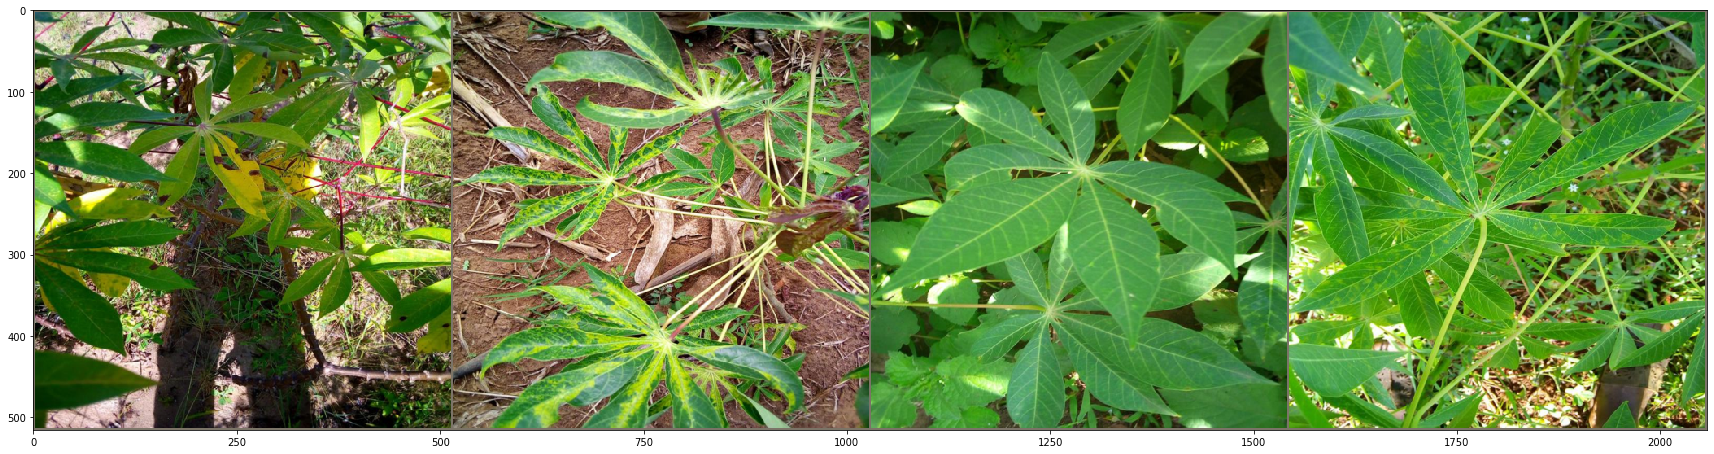

In [71]:
batch_size = 4
test_dataset = TestDataset(train, mode='Normalize', transform=data_transforms, crop=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

img, label = next(iter(test_loader))
out = torchvision.utils.make_grid(img)
plt.figure(figsize=(30, 30))
imshow(out)

### Augmentation_2: RandomHorizontalFlip

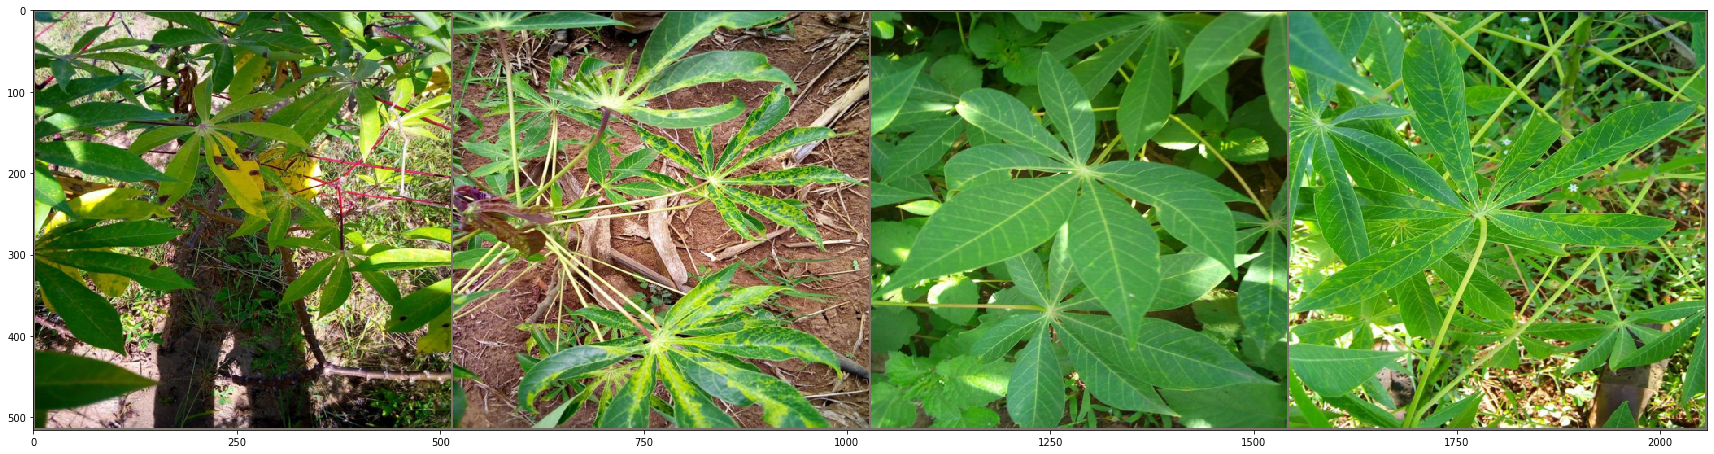

In [72]:
batch_size = 4
test_dataset = TestDataset(train, mode='RandomHorizontalFlip', transform=data_transforms, crop=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

img, label = next(iter(test_loader))
out = torchvision.utils.make_grid(img)
plt.figure(figsize=(30, 30))
imshow(out)

### Augmentation_3: RandomResizedCrop

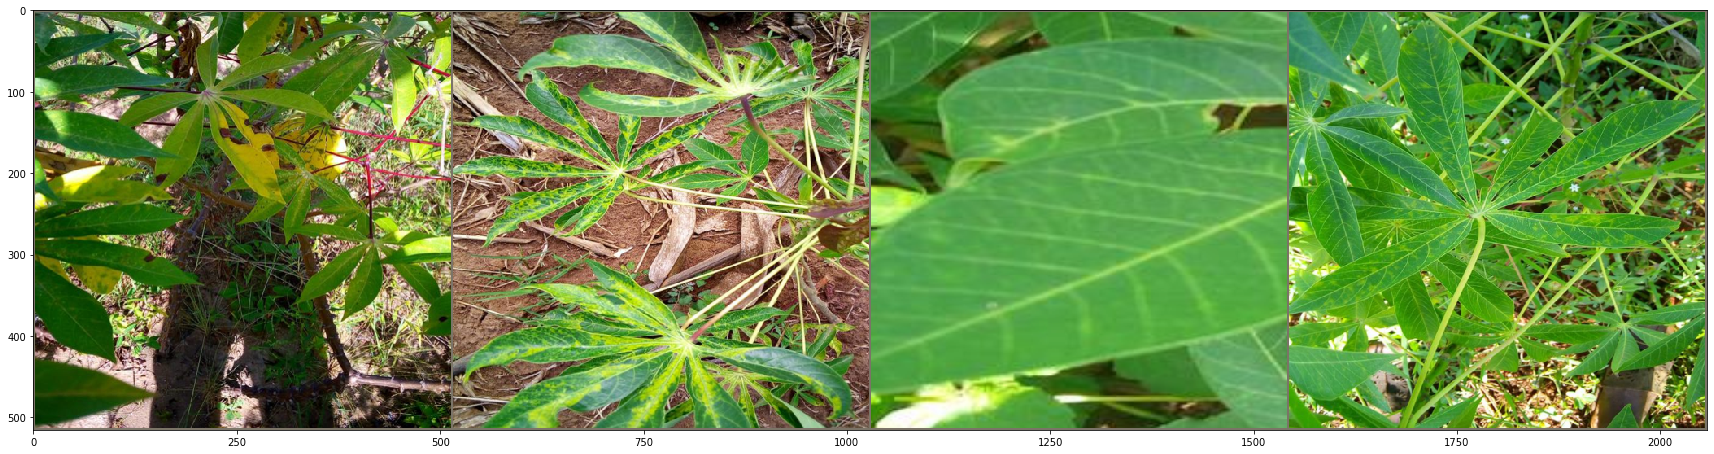

In [73]:
batch_size = 4
test_dataset = TestDataset(train, mode='RandomResizedCrop', transform=data_transforms, crop=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

img, label = next(iter(test_loader))
out = torchvision.utils.make_grid(img)
plt.figure(figsize=(30, 30))
imshow(out)